In [1]:
%load_ext autoreload
%autoreload 2

import glob
import logging
import numpy as np
from importlib import reload  # Not needed in Python 2

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.models import ResNet
from torch.utils.data import DataLoader,Dataset


from dataset.ASdataset import AS_Data
from dataset.ASdataset_obs_train_input import AS_Data_obs

from model import res8,UNet,UNet_Res

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
reload(logging)
logging.basicConfig(level=logging.INFO,#控制台打印的日志级别
                    filename='logging.txt',
                    filemode='a',##模式，有w和a，w就是写模式，每次都会重新写日志，覆盖之前的日志
                    #a是追加模式，默认如果不写的话，就是追加模式
                    format=
                    '%(asctime)s : %(message)s',
                    )

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

def image_show(im,title = '',r=10,base=80):
    im[:r,:r] = base
    im[r,r] = 0
    im[im>base] = base
    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()
    
# logging.info('\n\n\n\n\n')
# logging.info('with 3 conv grid to concat\n')
# logging.info('2res block, use simple feature: EM inventory simple,2d ALL,3d ALL\n')


class Focal_loss_regression(nn.Module):
    def __init__(self,max_update=10,_lambda=2,):
        super(Focal_loss_regression,self).__init__()
        self._lambda = _lambda
        max_update = np.power(1/max_update,1/_lambda)
        max_update = 1/max_update
        max_update = 1/(max_update-1)
        self.max_update = max_update
        
    def forward(self,pred,target):
        diff_abs = torch.abs(pred-target)
        diff_max = (1+self.max_update)*torch.max(diff_abs)
#         diff_max.detach()
        rate = torch.pow((1-1/diff_max*diff_abs)**self._lambda,-1)
        diff_abs = rate*diff_abs
        
#         return diff_abs
        return torch.mean(diff_abs)

In [2]:

cfg = {'EM':'/AS_data/Emis_npy/EM_2015_*',
      'label':'/AS_data/Conc_npy/O3_2015_*',
      'grid':'/AS_data/Grid_npy/grid_27_182_232.npy',
      'METCRO2D':'/AS_data/METCRO2D_npy/METCRO2D_2015_*',
      'METCRO3D':'',
      'METCRO3D_5height':'',
      'obs_label':'/AS_data/obs_npy/obs2015_*'}
# cfg = {'EM':'/AS_data/Emis_npy/EM_2015_07*',
#         'label':'/AS_data/Conc_npy/O3_2015_07*',
#         'grid':'/AS_data/Grid_npy/grid_27_182_232.npy',
#         'METCRO2D':'/AS_data/METCRO2D_npy/METCRO2D_2015_07*',
#         'METCRO3D':'',
#         'METCRO3D_5height':'',
#         'obs_label':'/AS_data/obs_npy/obs2015_7_*'}

print('train data is loading ')
Data = AS_Data_obs(cfg,left = 0,right = 1,window = 6)
trainloader = DataLoader(Data,batch_size=1,shuffle=True)
print(len(Data))

# print('test data is loading ')
# test_Data = AS_Data_obs(cfg,left = 0.75,right = 0.98,window = 6)
# testloader = DataLoader(test_Data,batch_size=1,shuffle=False)
# print(len(test_Data))

train data is loading 
/AS_data/Conc_npy/O3_2015_01_744_182_232.npy   is loading
/AS_data/Conc_npy/O3_2015_02_672_182_232.npy   is loading
/AS_data/Conc_npy/O3_2015_04_720_182_232.npy   is loading
/AS_data/Conc_npy/O3_2015_07_744_182_232.npy   is loading
/AS_data/Conc_npy/O3_2015_10_744_182_232.npy   is loading
/AS_data/Emis_npy/EM_2015_01_744_51_182_232.npy   is loading
/AS_data/Emis_npy/EM_2015_02_672_51_182_232.npy   is loading
/AS_data/Emis_npy/EM_2015_04_720_51_182_232.npy   is loading
/AS_data/Emis_npy/EM_2015_07_744_51_182_232.npy   is loading
/AS_data/Emis_npy/EM_2015_10_744_51_182_232.npy   is loading
/AS_data/METCRO2D_npy/METCRO2D_2015_01_744_34_182_232.npy   is loading
/AS_data/METCRO2D_npy/METCRO2D_2015_02_672_34_182_232.npy   is loading
/AS_data/METCRO2D_npy/METCRO2D_2015_04_720_34_182_232.npy   is loading
/AS_data/METCRO2D_npy/METCRO2D_2015_07_744_34_182_232.npy   is loading
/AS_data/METCRO2D_npy/METCRO2D_2015_10_744_34_182_232.npy   is loading
/AS_data/obs_npy/obs2015_01

In [3]:
class Tensor_Parameter(nn.Module):
    def __init__(self,):
        super(Tensor_Parameter,self).__init__()
        self.Input = nn.Parameter(torch.zeros(1))
    
    def forward(self,x):
        self.Input.data = x
        return self.Input

In [4]:
# test_model = res8(51+34,27,inplanes=64,layers = [2],T=24) #+5*16
# name = 'res_2layer_correctdata'
# test_model.load_state_dict(torch.load('model_save/res_2layer_9_epoch.t'))
test_model = UNet(51+34,27,T=6,bilinear=False) #+80
t2p = Tensor_Parameter()

name = 'unet2_1month'

test_model.to(device)
t2p.to(device)
criterion = torch.nn.L1Loss()
# optimizer = torch.optim.Adam(test_model.parameters(),lr=1e-3)
optimizer = torch.optim.Adam(t2p.parameters(),lr=1e-3)
test_model.load_state_dict(torch.load('model_save/o3_best_unet2_1month_65_epoch.t'))

<All keys matched successfully>

In [5]:
def score(model,loader,criterion= nn.L1Loss() ):
    model.eval()
    ls = []
    for idx,i in enumerate(loader):
        with torch.no_grad():
            indexes,input,grid,yt_1,label,obs = i[0],i[1],i[2],i[3],i[4],i[5]
            yt_1 = torch.unsqueeze(yt_1,1)
            input,grid,yt_1,label,obs = input.to(device),grid.to(device),yt_1.to(device),label.to(device),obs.float().to(device)
            input = t2p(input)
            y_pred = model(input,grid,yt_1)
            y_pred = torch.squeeze(y_pred) #,dim = 2)
            y_pred = y_pred.view(label.shape)
            
            Data.update_labels(indexes,y_pred)
            if torch.sum(obs!=-999)==0:
                continue

            
            loss = criterion(y_pred[obs!=-999],obs[obs!=-999])
            ls.append(loss.cpu().data)
        
    return np.mean(np.array(ls))

In [6]:

# input = torch.randn(3, 5, requires_grad=True)
# print(input)
# target = torch.randn(3, 5, requires_grad=True)
# for i in range(1000):
#     pred  = model(input)
#     optimizer.zero_grad()
#     loss = F.l1_loss(pred, target)
#     loss.backward()
#     optimizer.step()
# #     print(loss)
#     input = pred

In [37]:
test_score_L1 = score(test_model,trainloader,criterion = nn.L1Loss()) 
logging.info('-------------cur test loss L1:  {}'.format(test_score_L1))
print('-------------cur test loss L1:  {}'.format(test_score_L1))

-------------cur test loss L1:  10.270524024963379


In [ ]:

for epoch in range(50):
    logging.info('-----------{}-----------'.format(epoch))
    ls = []
    
    test_model.eval()
    test_model.rnn.train()
    for idx,i in enumerate(trainloader):
        
        indexes,input,grid,yt_1,label,obs = i[0],i[1],i[2],i[3],i[4],i[5]
        yt_1 = torch.unsqueeze(yt_1,1)
        input,grid,yt_1,label,obs = input.to(device),grid.to(device),yt_1.to(device),label.to(device),obs.to(device)
        input = t2p(input)
        y_pred = test_model(input,grid,yt_1)

        y_pred = torch.squeeze(y_pred) #,dim = 2)
        if torch.sum(obs!=-999)==0:
            continue
        optimizer.zero_grad()
        
        y_pred = y_pred.view(label.shape)
        loss = criterion(y_pred[obs!=-999],obs[obs!=-999])
        loss.backward()
        optimizer.step()
        ls.append(loss.cpu().data)
        
        #udpate input parameter
        Data.update(indexes,t2p.Input.data)

#         Data.update_labels(indexes,y_pred)
#         if len(ls)%400==0:
#             logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    print('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    test_score_L1 = score(test_model,trainloader,criterion = nn.L1Loss()) 
    logging.info('-------------cur test loss L1:  {}'.format(test_score_L1))
    
#     if epoch%5 == 0:
#         torch.save(test_model.cpu().state_dict(),'model_save/finetune_input_{}_{}_epoch.t'.format(name,epoch))
#         test_model.to(device)

epoch 0 cur loss 31.16423225402832


In [40]:
for idx,month in enumerate(['01','02','04','07','10']):
    np.save('/AS_data/finetune_input_npy/month_{}_finetune_input.npy'.format(month),Data.EM[idx])

In [31]:
Data.METCRO2D[0].shape

(729, 34, 182, 232)

In [32]:
Data.EM[0].shape

(729, 51, 182, 232)

0.10913986606003973


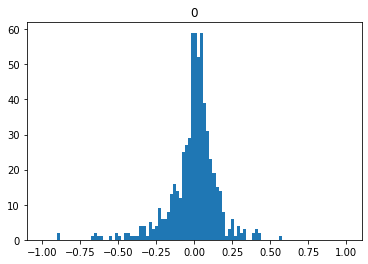

0.2949287426190388


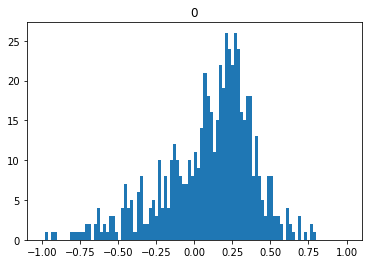

0.382105664493212


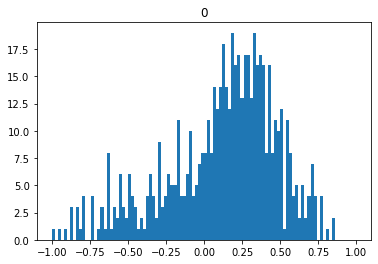

0.10795537719406403


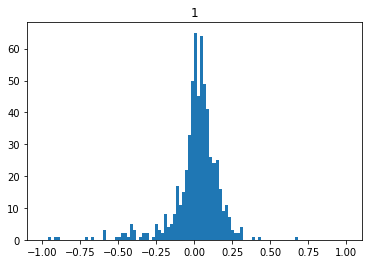

0.309338593513314


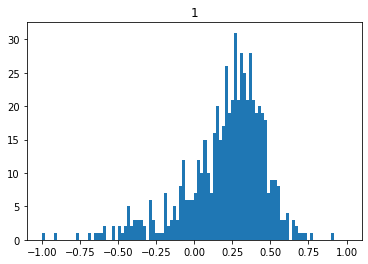

0.38544474668454776


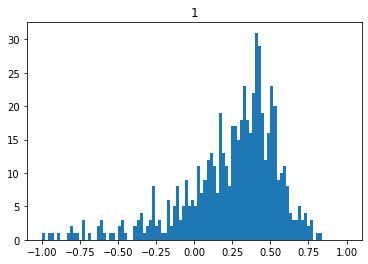

0.13722161704729713


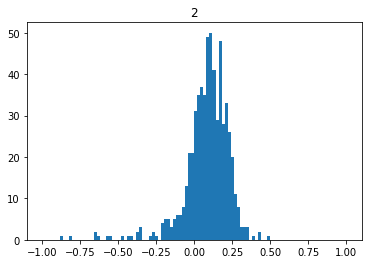

0.30677179146033323


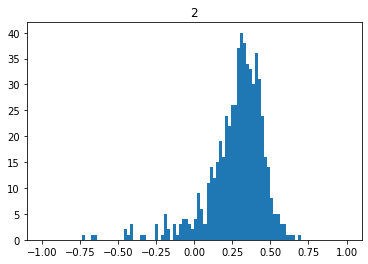

0.4262153863449966


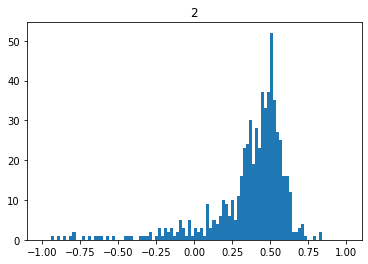

0.14716847187016718


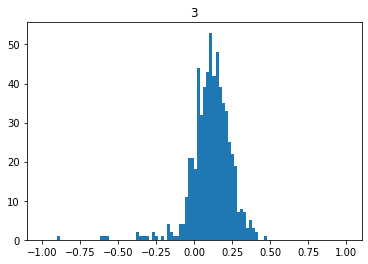

0.36511801345216444


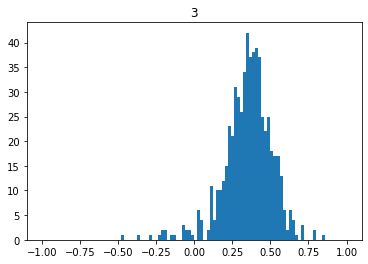

0.4965311591771812


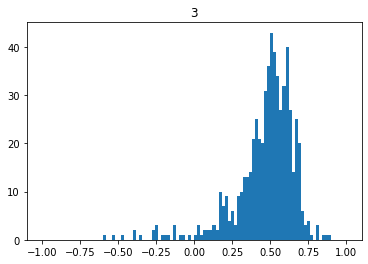

0.12102850039230918


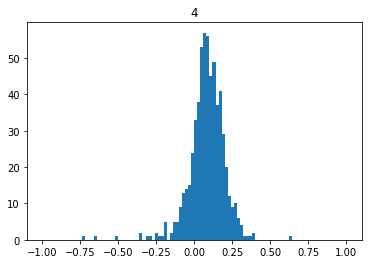

0.2911999089793098


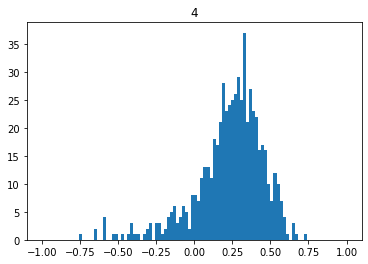

0.394690359186889


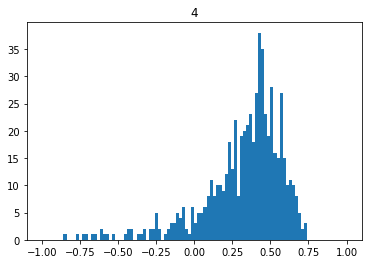

In [39]:
for i in range(len(Data.obs_label)):
    obs = Data.obs_label[i].copy()
    fine_l = Data.finetune_label[i].copy()
    ctm_l = Data.label[i].copy()
    
    obs[Data.obs_label[i]==-999] = 0
    fine_l[Data.obs_label[i]==-999] = 0
    ctm_l[Data.obs_label[i]==-999] = 0
    
    obs = np.sum(obs,axis = 0)
    fine_l = np.sum(fine_l,axis = 0)
    ctm_l = np.sum(ctm_l,axis = 0)

    a = (obs-fine_l)/(obs+1e-3)
    b = (fine_l-ctm_l)/(obs+1e-3)
    c = (obs-ctm_l)/(obs+1e-3)
    
    print(np.mean(np.abs(a[a!=0])))
    plt.hist(a[a!=0].reshape(-1),range=(-1,1),bins = 100)
    plt.title(i)
    plt.show()
    
    plt.hist(b[b!=0].reshape(-1),range=(-1,1),bins = 100)
    print(np.mean(np.abs(b[b!=0])))
    plt.title(i)
    plt.show()
    
    plt.hist(c[c!=0].reshape(-1),range=(-1,1),bins = 100)
    print(np.mean(np.abs(c[c!=0])))
    plt.title(i)
    plt.show()

In [34]:
for filename in sorted(glob.glob('')):
        print(filename+'   is loading')
        EM = np.load(filename)
#             EM = simplify_matrix(EM,1,l_EM)
        tick,_,W,H = EM.shape
        self.EM.append(EM[int(left*tick):int(right*tick)].copy())
        del EM

51

In [58]:
for i in range(len(Data.EM)):
    for j in range(Data.EM[0].shape[1]):
        fine_input = Data.EM[i][:,j].copy()
        org_input = Data.finetune_label[i][:,j].copy()

        obs[Data.obs_label[i]==-999] = 0
        fine_l[Data.obs_label[i]==-999] = 0
        ctm_l[Data.obs_label[i]==-999] = 0

        obs = np.sum(obs,axis = 0)
        fine_l = np.sum(fine_l,axis = 0)
        ctm_l = np.sum(ctm_l,axis = 0)

        a = (obs-fine_l)/(obs+1e-3)
        b = (fine_l-ctm_l)/(obs+1e-3)
        c = (obs-ctm_l)/(obs+1e-3)

        print(np.mean(np.abs(a[a!=0])))
        plt.hist(a[a!=0].reshape(-1),range=(-1,1),bins = 100)
        plt.title(i)
        plt.show()

        plt.hist(b[b!=0].reshape(-1),range=(-1,1),bins = 100)
        print(np.mean(np.abs(b[b!=0])))
        plt.title(i)
        plt.show()

        plt.hist(c[c!=0].reshape(-1),range=(-1,1),bins = 100)
        print(np.mean(np.abs(c[c!=0])))
        plt.title(i)
        plt.show()

In [60]:
a[a>0]

array([2.65592700e-01, 2.72089488e-01, 3.21977242e-01, 7.55372109e-02,
       1.81072898e-01, 8.33725843e-02, 2.04191687e-01, 7.85699803e-02,
       8.84539791e-02, 2.02114249e-01, 9.36465590e-02, 6.03010411e-02,
       4.45491151e-03, 1.59333241e-01, 7.95603370e-02, 2.18974538e-01,
       6.68553047e-02, 1.80287698e-01, 6.42548645e-03, 2.95117648e-02,
       1.52836783e-01, 3.83880961e-01, 5.84267206e-01, 1.72940988e-02,
       6.22834891e-02, 9.07032916e-02, 5.66033109e-02, 1.30660263e-02,
       2.64340174e-03, 2.51622106e-02, 2.64415944e-02, 2.32362385e-01,
       1.69812119e-01, 3.98784164e-02, 1.60173827e-01, 4.24626843e-02,
       2.05665226e-02, 2.59330957e+00, 1.54323979e-01, 6.30805930e-01,
       2.70149841e-01, 2.49812355e-01, 3.15624351e-01, 9.58569233e-02,
       7.31493291e-02, 7.49099018e-02, 3.63840627e-02, 4.41856690e-02,
       6.11375591e-02, 5.49203223e-02, 6.11259569e-02, 7.87065888e-02,
       6.42937616e-02, 2.93614003e-01, 1.61768577e-01, 1.70711612e-01,
      

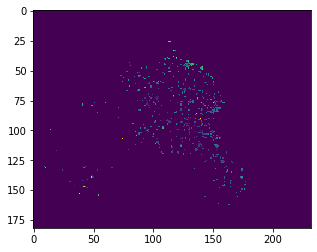

In [54]:
plt.imshow(obs)

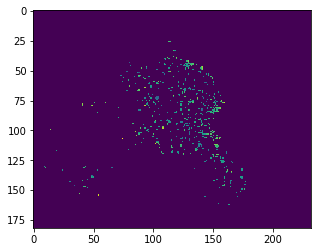

In [53]:
plt.imshow(fine_l)

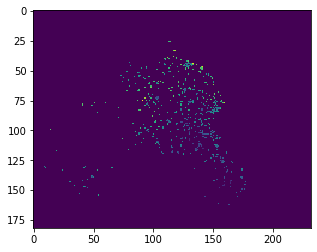

In [55]:
plt.imshow(ctm_l)

Signature:
plt.hist(
    x,
    bins=None,
    range=None,
    density=None,
    weights=None,
    cumulative=False,
    bottom=None,
    histtype='bar',
    align='mid',
    orientation='vertical',
    rwidth=None,
    log=False,
    color=None,
    label=None,
    stacked=False,
    normed=None,
    *,
    data=None,
    **kwargs,
)
Docstring:
Plot a histogram.

Compute and draw the histogram of *x*.  The return value is a tuple
(*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*, [*patches0*,
*patches1*,...]) if the input contains multiple data.  See the
documentation of the *weights* parameter to draw a histogram of
already-binned data.

Multiple data can be provided via *x* as a list of datasets
of potentially different length ([*x0*, *x1*, ...]), or as
a 2-D ndarray in which each column is a dataset.  Note that
the ndarray form is transposed relative to the list form.

Masked arrays are not supported at present.

Parameters
----------
x : (n,) array or sequence of (n,) arrays


In [9]:
for idx,i in enumerate(trainloader):
        
    indexes,input,grid,yt_1,label,obs = i[0],i[1],i[2],i[3],i[4],i[5]
    break

tensor([ 53.,  54.,  28.,  11.,  43.,  35.,  58.,  44.,  46.,  39.,  49.,  48.,
         62.,  50.,  44.,  44.,  87.,  30.,  25.,  55.,  40.,  37.,  44.,  36.,
         59.,  55.,  51.,  52.,  70.,  48.,  56.,  49.,  51.,  54.,  73.,  67.,
         56.,  59.,  40.,   6.,  32.,  16.,   5.,  51.,  58.,  90.,  56.,  18.,
         18.,  59.,  70., 129.,  88.,  59.,  32.,  20.,  45.,  64.,  58.,  43.,
         72.,  36.,  82.,  44.,  94.,  87.,  59.,  36.,  35.,  66.,  16.,  84.,
         41.,  73.,  30.,  20.,  17.,  68.,  85.,  89.,  10.,  54., 111., 249.,
         70., 112.,  40.,  41.,  89., 115.,  79., 119., 119.,  57.,  93.,  99.,
         33., 114.,  77.,  91.,  44., 114.,  75.,  54.,  93.,  87., 111.,  38.,
         32.,  49.,  74.,  46.,  43.,  65.,  85., 162., 176.,  46.,  85., 102.,
         77.,   6., 111., 134.,  34.,  33.,  53., 159.,  91.,  38.,   3.,  79.,
        114.,   6.,  24.,  42.,  90.,  24.,  75.,  72.,  34.,  80.,  71.,  53.,
        104.,  79.,  29.,  17.,   9.,  1